<a href="https://colab.research.google.com/github/Emekaborisama/Loan-default-prediction-with-Tensorflow/blob/main/DSN_Loan_prediction_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **COLAB INSTALLATIONS AND DRIVE MOUNTING**

In [ ]:
!pip install catboost 

     |████████████████████████████████| 66.1MB 46kB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
import os
os.chdir("/content/drive/My Drive/DSN")

Mounted at /content/drive/


### **IMPORT NECESSARY LIBRARIES**

This solution to the Expresso Churn prediction challenge is a stack of three models(CatBoost, XGBoost and LGBM).

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, log_loss
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb
import catboost as cat_
import seaborn as sns
import lightgbm as lgb

### **HELPER FUNCTION**

This is where the cross validation loop and other processes are built for easy training and stacking throughout our workflow...  In this class, a variable "val_p" has been created. This is where all the predictions based on the validation set from each cross validation loop is stored, resulting to us having predictions based on the whole training data itself. Also, another 
variable "test_p" is where the test set predictions are stored.

This function was created by @[makkay](https://github.com/marx-keyz/Winning-Solution-Expresso-Churn-Prediction-Challenge-by-DSN)

In [ ]:
class func() :   
    def __init__(self, train, label, test, model, model_type, random_state):
        self.train, self.label, self.test = train, label, test
        self.model, self.model_type = model, model_type
        self.random_state = random_state
        
        assert self.model_type in ('catboost', 'xgboost', 'lgbm'), 'Incorrect model_type'
    def __call__(self, plot = True):
        return self.fit(plot)

    def fit(self, plot):
        def catboost_fit(X_train, X_test, y_train, y_test):
            self.model.fit(X_train,y_train,eval_set=[(X_test,y_test)],early_stopping_rounds=500,
                           verbose=50,use_best_model=True)
            x_test_predict = self.model.predict_proba(X_test)[:,1]
            x_train_predict = self.model.predict_proba(X_train)[:,1]
            self.val_p[test_index] = x_test_predict
            self.test_p += self.model.predict_proba(self.test)[:,1]
            return x_test_predict, x_train_predict

        def xgboost_fit(X_train, X_test, y_train, y_test):
            self.model.fit(X_train, y_train, early_stopping_rounds = 30, eval_metric="auc",
                           eval_set=[(X_test, y_test)], verbose = True)
            x_test_predict = self.model.predict_proba(X_test, ntree_limit = self.model.get_booster().best_ntree_limit)[:,1]
            x_train_predict = self.model.predict_proba(X_train, ntree_limit = self.model.get_booster().best_ntree_limit)[:,1]
            self.val_p[test_index] = x_test_predict
            self.test_p += self.model.predict_proba(self.test, ntree_limit = self.model.get_booster().best_ntree_limit)[:,1]
            return x_test_predict, x_train_predict

        def lgbm_fit(X_train, X_test, y_train, y_test):
            self.model.fit(X_train, y_train, early_stopping_rounds = 30, eval_metric="auc",
                           eval_set=[(X_test, y_test)], verbose = True)
            x_test_predict = self.model.predict_proba(X_test, num_iteration = self.model.best_iteration_)[:,1]
            x_train_predict = self.model.predict_proba(X_train, num_iteration = self.model.best_iteration_)[:,1]
            self.val_p[test_index] = x_test_predict
            self.test_p += self.model.predict_proba(self.test, num_iteration = self.model.best_iteration_)[:,1]
            return x_test_predict, x_train_predict


        self.val_p = np.zeros(self.train.shape[0])
        mean_val = []
        mean_train = []
        self.test_p = np.zeros(self.test.shape[0])
        splits = 5
        kf = StratifiedKFold(n_splits = splits)
        for fold_count, (train_index, test_index) in enumerate(kf.split(self.train, self.label)):
            X_train,X_test = self.train.iloc[train_index],self.train.iloc[test_index]
            y_train,y_test = self.label.iloc[train_index],self.label.iloc[test_index]

            print(f"================================Fold{fold_count+1}====================================")
            if self.model_type == 'catboost': x_test_predict, x_train_predict = catboost_fit(X_train, X_test, y_train, y_test)
            elif self.model_type == 'xgboost': x_test_predict, x_train_predict = xgboost_fit(X_train, X_test, y_train, y_test)
            elif self.model_type == 'lgbm': x_test_predict, x_train_predict = lgbm_fit(X_train, X_test, y_train, y_test)

            print('\nValidation scores', roc_auc_score(y_test, x_test_predict), log_loss(y_test, x_test_predict))
            print('Training scores', roc_auc_score(y_train, x_train_predict), log_loss(y_train, x_train_predict))
            mean_val.append(roc_auc_score(y_test, x_test_predict))
            mean_train.append(roc_auc_score(y_train, x_train_predict))

        if plot:
            feat_imp = pd.DataFrame(sorted(zip(self.model.feature_importances_,self.train.columns)), columns=['Value','Feature'])
            plt.figure(figsize=(30,25))
            sns.barplot(x="Value", y="Feature", data=feat_imp.sort_values(by="Value", ascending=False))
            plt.ylabel('Feature Importance Score')
            plt.show()
        print(np.mean(mean_val), np.mean(mean_train), np.std(mean_val))
        return self.val_p, self.test_p/splits, self.model

### **DATA IMPORT AND CLEANING**

In [ ]:
df = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')

In [ ]:
df1 = df.fillna(method = 'pad')
test1 = test.fillna(method = 'pad')

df2= df1.fillna(0)
df2.shape

test2 = test1.fillna(0)

In [ ]:
def one_hot_encode(df):
    """ One-hot encodes the df's categorical features. """
    cat_features = ['form_field47', 'form_field20', 'form_field39']
    
    for feat in cat_features:
        dummy = pd.get_dummies(df[feat], prefix=feat)
        df = pd.concat([df, dummy], axis = 1)
        df.drop(feat, axis=1, inplace=True)
    return df 

In [ ]:
df3i= one_hot_encode(df3)

In [ ]:
test4 = one_hot_encode(test3)

In [ ]:
df3.shape

(55993, 93)

# Preprocessing

In [ ]:
df2['form_field60'] = df2['form_field1'] + df2['form_field42'] 
df2['form_field61'] = df2['form_field1'] + df2['form_field47']
df2['form_field62'] = df2['form_field1'] + df2['form_field10'] 
df2['form_field63'] = df2['form_field10'] + df2['form_field38'] 
df2['form_field64'] = df2['form_field3'] + df2['form_field19'] + df2['form_field2']
df2['form_field65'] = df2['form_field6'] + df2['form_field10'] + df2['form_field28']
df2['form_field66'] = df2['form_field2'] + df2['form_field38'] + df2['form_field36']
df2['form_field67'] = df2['form_field36'] + df2['form_field2'] + df2['form_field14']
df2['form_field68'] = df2['form_field1'] + df2['form_field29'] + df2['form_field8']
df2['form_field69'] = df2['form_field1'] * df2['form_field28'] + df2['form_field42']
df2['form_field70'] = df2['form_field1'] + df2['form_field42'] + df2['form_field8']
df2['form_field71'] = df2['form_field1'] + df2['form_field28']
df2['form_field72'] = df2['form_field1'] * df2['form_field2']
df2['form_field73'] = df2['form_field1']+ df2['form_field47']
df2['form_field74'] = df2['form_field1'] 
df2['form_field75'] = df2['form_field47'] 
df2['form_field76'] = df2['form_field2']
df2['form_field77'] = df2['form_field64'] 
df2['form_field78'] = df2['form_field1'] 
df2['form_field79'] = df2['form_field1'] 
df2['form_field80'] = df2['form_field7']
df2['form_field81'] = df2['form_field64'] 
df2['form_field82'] = df2['form_field60'] 
df2['form_field83'] = df2['form_field10'] 
df2['form_field84'] = df2['form_field6'] 
df2['form_field85'] = df2['form_field75']
df2['form_field86'] = df2['form_field47'] 


In [ ]:
test2['form_field60'] = test2['form_field1'] + test2['form_field42']
test2['form_field61'] = test2['form_field1'] + test2['form_field47']
test2['form_field62'] = test2['form_field1'] + test2['form_field10'] 
test2['form_field63'] = test2['form_field10'] + test2['form_field38'] 
test2['form_field64'] = test2['form_field3'] + test2['form_field19'] + test2['form_field2']
test2['form_field65'] = test2['form_field6'] + test2['form_field10'] + test2['form_field28']
test2['form_field66'] = test2['form_field2'] + test2['form_field38'] + test2['form_field36']
test2['form_field67'] = test2['form_field36'] + test2['form_field2'] + test2['form_field14']
test2['form_field68'] = test2['form_field1'] + test2['form_field29'] + test2['form_field8']
test2['form_field69'] = test2['form_field1'] * test2['form_field28'] + test2['form_field3']
test2['form_field70'] = test2['form_field1'] + test2['form_field42'] + test2['form_field8']
test2['form_field71'] = test2['form_field1'] + test2['form_field28']
test2['form_field72'] = test2['form_field1'] * test2['form_field2']
test2['form_field73'] = test2['form_field1']+ test2['form_field47']
test2['form_field74'] = test2['form_field1'] 
test2['form_field75'] = test2['form_field42'] 
test2['form_field76'] = test2['form_field2']
test2['form_field77'] = test2['form_field64'] 
test2['form_field78'] = test2['form_field1'] 
test2['form_field79'] = test2['form_field1'] 
test2['form_field80'] = test2['form_field7']
test2['form_field81'] = test2['form_field64']
test2['form_field82'] = test2['form_field60'] 
test2['form_field83'] = test2['form_field10'] 
test2['form_field84'] = test2['form_field6'] 
test2['form_field85'] = test2['form_field75']
test2['form_field86'] = test2['form_field47']  

In [ ]:
test1.shape

(24000, 51)

In [ ]:
test2.shape

(24000, 62)

In [ ]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()

In [ ]:
df2= df2.apply(LabelEncoder().fit_transform)

In [ ]:
test2 = test2.apply(LabelEncoder().fit_transform)

In [ ]:
df2['form_field47'] = labelencoder.fit_transform(df2['form_field47'])
test2['form_field47'] = labelencoder.fit_transform(test2['form_field47'])

In [ ]:
df2['default_status'] = labelencoder.fit_transform(df2['default_status'])
#test['default_status'] = labelencoder.fit_transform(test['default_status'])

In [ ]:
df2['form_field48'] = labelencoder.fit_transform(df2['form_field48'])

Extract training data, test data and target

# Cross Validaition


In [ ]:
# Separating the independent and target variable on both data set 
X = df2.drop(columns =['Applicant_ID', 'default_status'], axis = 1) 
y = df2['default_status'] 

xx_test= test2.drop(['Applicant_ID'], axis = 1)



In [ ]:

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=21)



In [ ]:
from sklearn.preprocessing import StandardScaler

from sklearn.preprocessing import MinMaxScaler
minscaler = MinMaxScaler()
scaler = StandardScaler()
x_train= scaler.fit_transform(X_train)
x_test= scaler.fit_transform(X_test)
xxx_test = scaler.fit_transform(xx_test)
X_train_1 = minscaler.fit_transform(X_train)
X_test_1 = minscaler.fit_transform(X_test)
xxx_test_1 = minscaler.fit_transform(xx_test)




### **MODEL 1 - CATBOOST**

The CATBOOST and XGBOOST models were trained on GPU(Google Colab) in order to save time. To train on CPU, you would have to remove the **task_type** and **devices** parameters.

In [ ]:

import xgboost as xgb
from sklearn import metrics

================================Fold1====================================
0:	learn: 0.7810024	test: 0.7789426	best: 0.7789426 (0)	total: 236ms	remaining: 39m 15s
50:	learn: 0.8531502	test: 0.8283993	best: 0.8291510 (31)	total: 6.84s	remaining: 22m 15s
100:	learn: 0.8684094	test: 0.8259370	best: 0.8291510 (31)	total: 13.8s	remaining: 22m 31s
150:	learn: 0.8792009	test: 0.8247156	best: 0.8291510 (31)	total: 20.6s	remaining: 22m 26s
200:	learn: 0.8875563	test: 0.8223997	best: 0.8291510 (31)	total: 27.4s	remaining: 22m 15s
250:	learn: 0.8965722	test: 0.8209841	best: 0.8291510 (31)	total: 34.1s	remaining: 22m 5s
300:	learn: 0.9039867	test: 0.8203793	best: 0.8291510 (31)	total: 40.8s	remaining: 21m 55s
350:	learn: 0.9095697	test: 0.8194636	best: 0.8291510 (31)	total: 47.5s	remaining: 21m 46s
400:	learn: 0.9154561	test: 0.8175799	best: 0.8291510 (31)	total: 54.2s	remaining: 21m 36s
450:	learn: 0.9200298	test: 0.8156802	best: 0.8291510 (31)	total: 1m	remaining: 21m 28s
500:	learn: 0.9257757	te

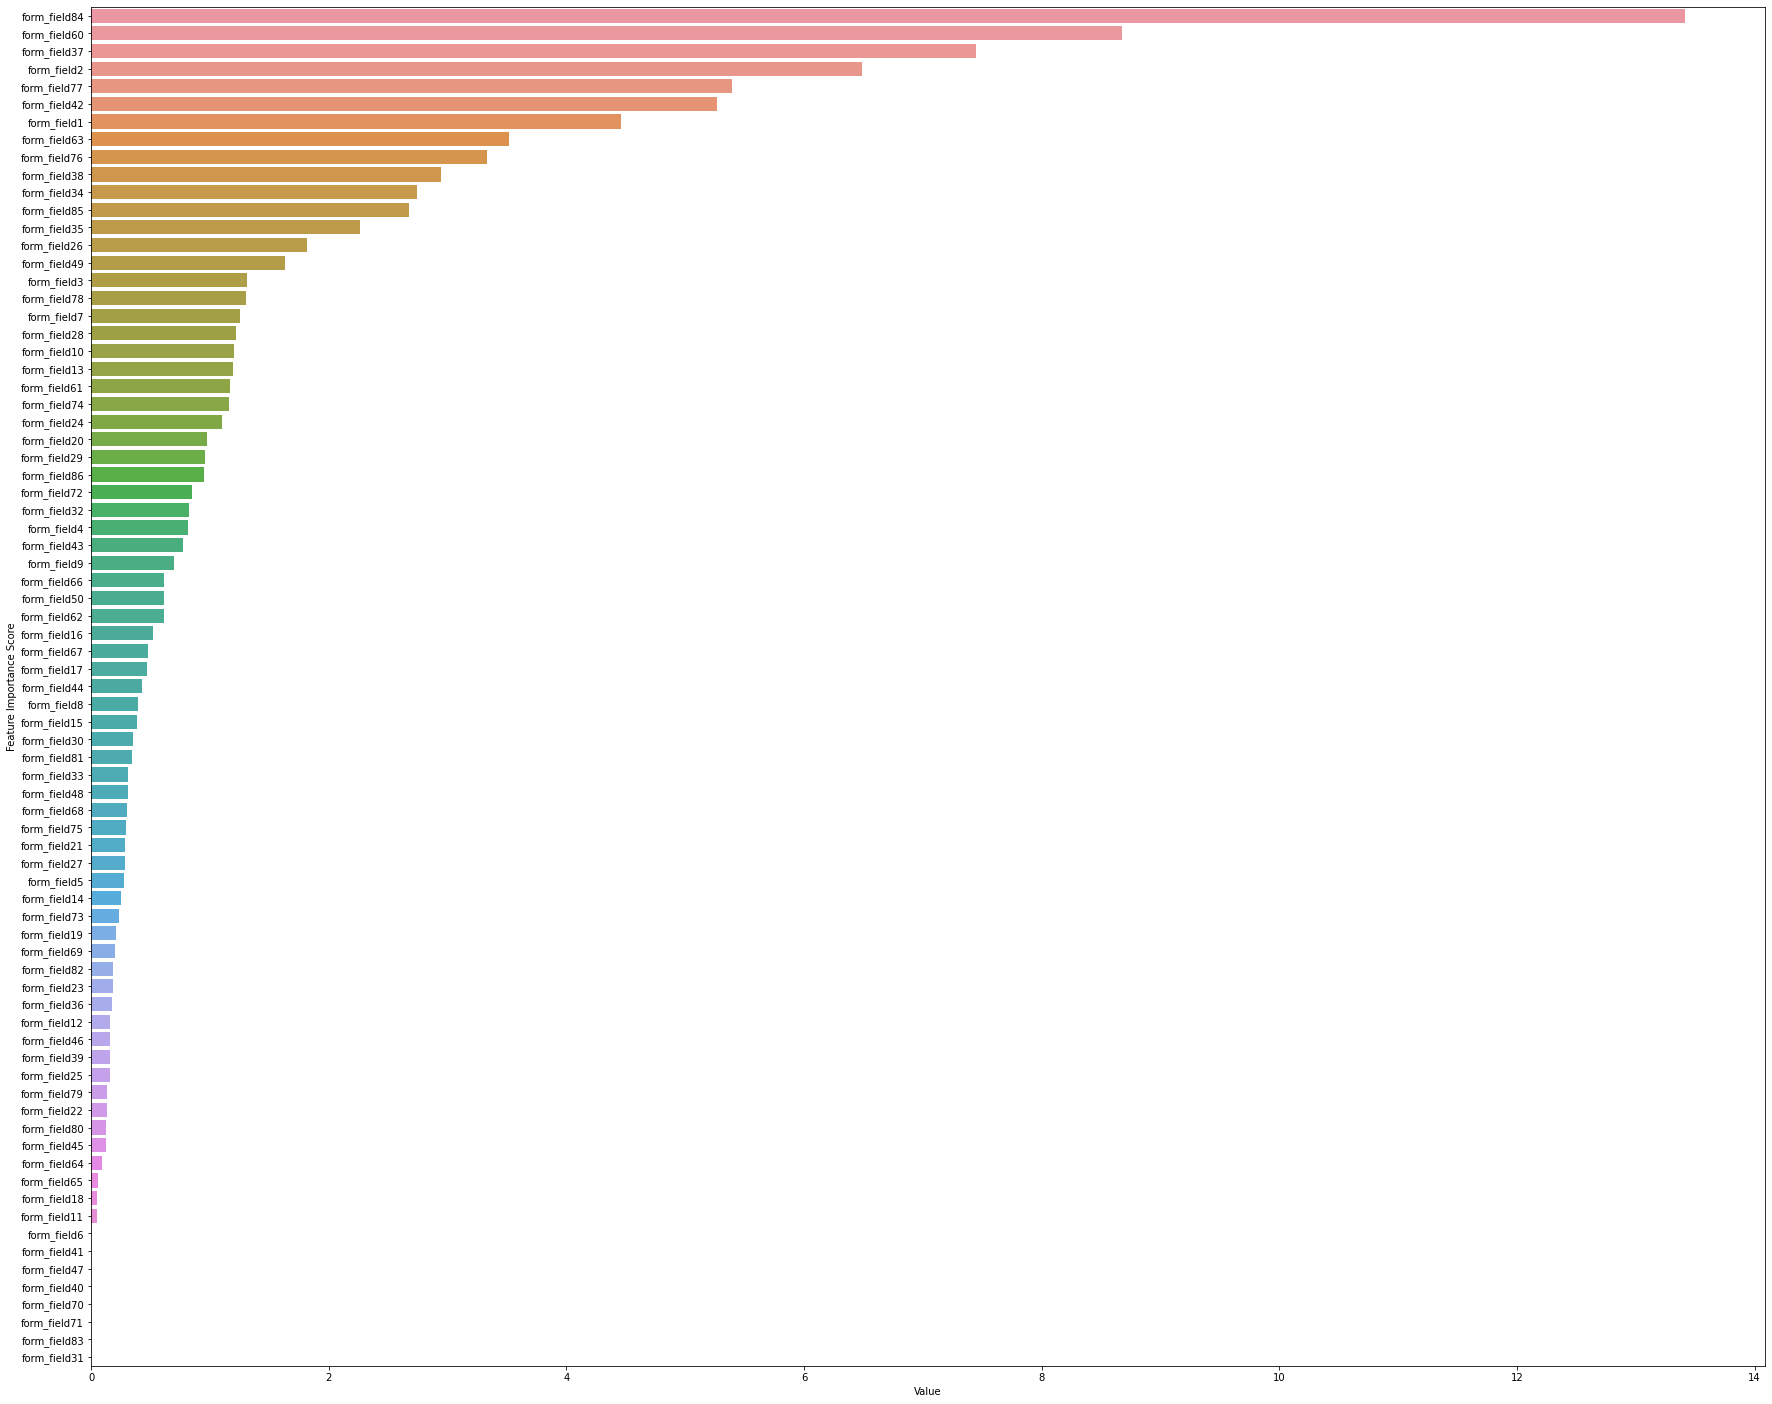

0.828724670117117 0.8468369465487973 0.00638543253039046


In [ ]:
catboost = cat_.CatBoostClassifier(n_estimators=10000,random_seed=41, learning_rate=0.6, max_depth=8, eval_metric='AUC', reg_lambda = 370, task_type="GPU", devices='0:1')

func_= func(X,y, xx_test, catboost,  'catboost', 1000)
val_p1, test_p1, model1 = func_()

### **MODEL 2 - XGBOOST**

To train on CPU, you would have to remove the **tree_method** and **gpu_id** parameters.

================================Fold1====================================
[0]	validation_0-auc:0.740728
Will train until validation_0-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.765852
[2]	validation_0-auc:0.781672
[3]	validation_0-auc:0.78323
[4]	validation_0-auc:0.786855
[5]	validation_0-auc:0.788082
[6]	validation_0-auc:0.789607
[7]	validation_0-auc:0.790471
[8]	validation_0-auc:0.792862
[9]	validation_0-auc:0.794157
[10]	validation_0-auc:0.797156
[11]	validation_0-auc:0.800057
[12]	validation_0-auc:0.801971
[13]	validation_0-auc:0.803914
[14]	validation_0-auc:0.806376
[15]	validation_0-auc:0.807331
[16]	validation_0-auc:0.808499
[17]	validation_0-auc:0.809912
[18]	validation_0-auc:0.812309
[19]	validation_0-auc:0.813267
[20]	validation_0-auc:0.813793
[21]	validation_0-auc:0.814442
[22]	validation_0-auc:0.815006
[23]	validation_0-auc:0.815901
[24]	validation_0-auc:0.816355
[25]	validation_0-auc:0.816887
[26]	validation_0-auc:0.817488
[27]	validation_0-auc:0.817782
[28]	

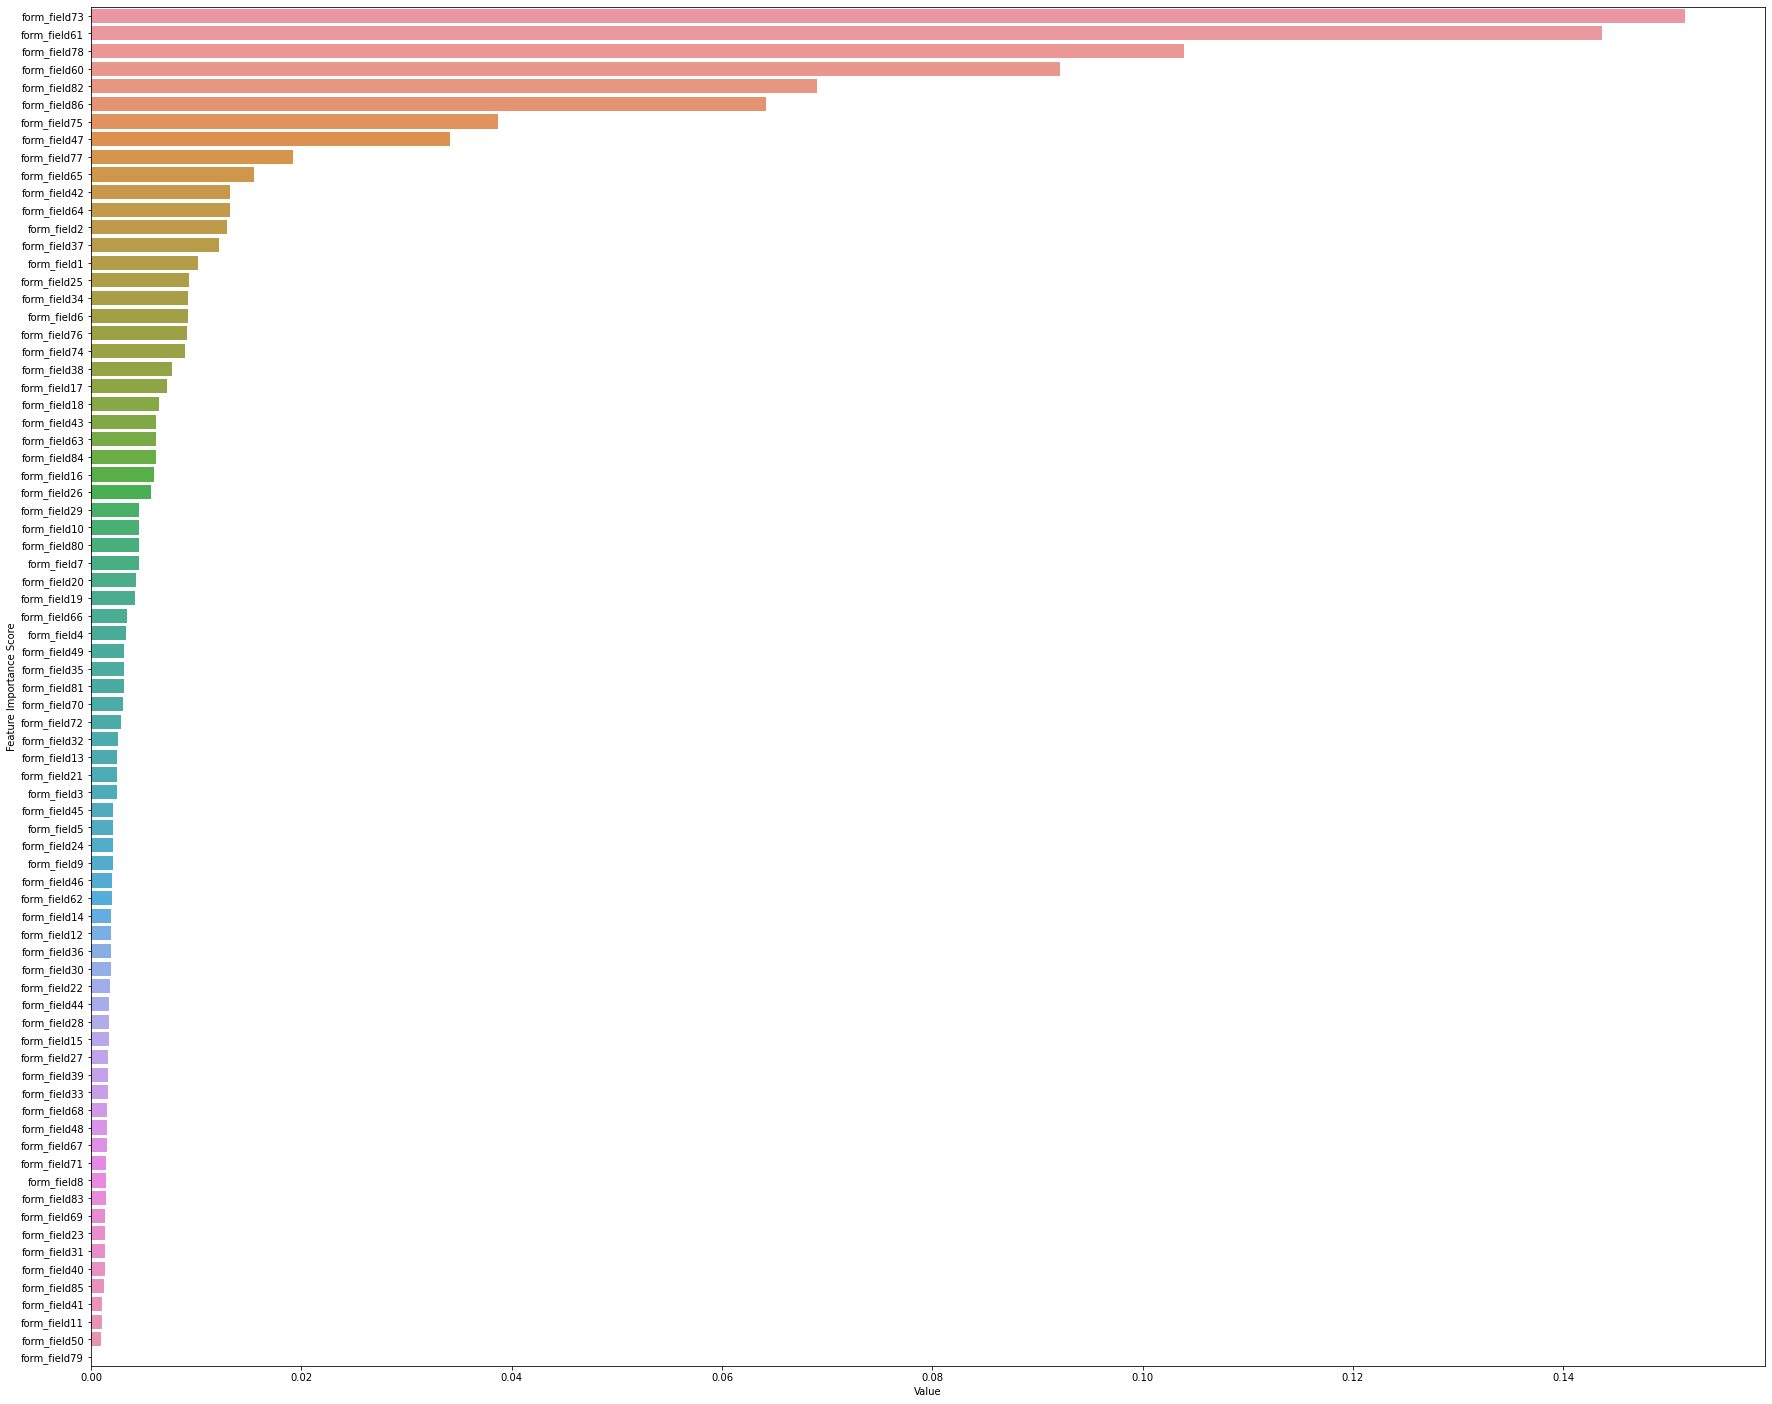

0.8332848109699167 0.8585262012140851 0.0058365991785536185


In [ ]:
xgboost = xgb.XGBClassifier(objective ='binary:logistic', 
                          eta = 0.99,
                          max_depth = 4, 
                          n_estimators = 5006,
                          reg_lambda = 500,
                          sub_sample = 0.8,
                          colsample_bytree = 0.8, tree_method='gpu_hist', gpu_id=0)

func_= func(X,y, xx_test, xgboost, 'xgboost', 1000)
val_p2, test_p2, model2 = func_()

### **STACKING**

To stack, we use a simple algorithm as a meta-learner(Linear Regression) to finetune our predictions. We train this algorithm with the predictions of validation sets from all algorithms and use to produce the final predictions with the combination of the test set predictions from all algorithms.

In [ ]:
val = val_p1**val_p1
test9 = test_p1 ** test_p1


In [ ]:
from sklearn.linear_model import  LinearRegression, Ridge, Lasso
stack = np.column_stack((val_p1, val_p2, val))
stack_p = np.column_stack((test_p1, test_p2, test9 ))



predict = LinearRegression().fit(stack, y).predict(stack_p)

### **SUBMISSION**

In [ ]:
df3.shape

(55993, 93)

In [ ]:


submission = pd.DataFrame({"Applicant_ID":test1["Applicant_ID"],
                           "default_status":predict})
submission.to_csv("submit10b.csv", index=False)

In [ ]:
p =  predictions.reshape(-1)

# Tensorflow


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Dropout
from tensorflow.keras.constraints import max_norm

In [ ]:
model = Sequential()

# https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw


# input layer
model.add(Dense(62,  activation='softmax'))
model.add(Dropout(0.2))

# hidden layer
model.add(Dense(39, activation='softmax'))
model.add(Dropout(0.2))

# hidden layer
model.add(Dense(19, activation='softmax'))
model.add(Dropout(0.2))

# output layer
model.add(Dense(units=1,activation='softmax'))

# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [ ]:
model.fit(x=x_train, 
          y=y_train, 
          epochs=100,
          batch_size=100,
          validation_data=(x_test, y_test), 
          )

Epoch 1/100
504/504 [==============================] - 1s 2ms/step - loss: 0.4691 - val_loss: 0.4315
Epoch 2/100
504/504 [==============================] - 1s 2ms/step - loss: 0.4382 - val_loss: 0.4234
Epoch 3/100
504/504 [==============================] - 1s 2ms/step - loss: 0.4324 - val_loss: 0.4257
Epoch 4/100
504/504 [==============================] - 1s 2ms/step - loss: 0.4286 - val_loss: 0.4219
Epoch 5/100
504/504 [==============================] - 1s 2ms/step - loss: 0.4262 - val_loss: 0.4204
Epoch 6/100
504/504 [==============================] - 1s 2ms/step - loss: 0.4244 - val_loss: 0.4200
Epoch 7/100
504/504 [==============================] - 1s 2ms/step - loss: 0.4228 - val_loss: 0.4204
Epoch 8/100
504/504 [==============================] - 1s 2ms/step - loss: 0.4222 - val_loss: 0.4175
Epoch 9/100
504/504 [==============================] - 1s 2ms/step - loss: 0.4199 - val_loss: 0.4172
Epoch 10/100
504/504 [==============================] - 1s 2ms/step - loss: 0.4200 - val_lo

In [ ]:
df2.shape

(56000, 74)

In [ ]:
model = Sequential()

# https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw


# input layer
model.add(Dense(73,  activation='relu'))
model.add(Dropout(0.2))

# hidden layer
model.add(Dense(39, activation='relu'))
model.add(Dropout(0.2))

# hidden layer
model.add(Dense(19, activation='soft'))
model.add(Dropout(0.2))

# output layer
model.add(Dense(units=1,activation='sigmoid'))

# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam')

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
predictions = model.predict_classes(xx_test)
#print(classification_report(y_test,predictions))